In [1]:
import numpy as np
from numpy import cos, sin, sqrt, arcsin, arctan2, radians, arctan
import matplotlib.pyplot as plt
import math as math_

np.set_printoptions(precision=2, suppress=True)  # 2 décimales, sans notation scientifique

## Définition des dimensions du Robot

In [2]:
## Angles
theta10 = 20
theta20 = 20


## Distances
O_T     = 80           # Longueur entre le centre du repère et le point T
### Bras 1
O_A1    = 0.0           # Longueur entre le centre du repère et le point A1
A1_A2   = 72.648        # Longueur entre le point A1 ('origine' du bras) et B1 (première pliure du bras).
A1_A3   = 0.0           # Longueur entre le point A1 et A3. (Valeur temporaire, je sais pas comment la calculer)

### Bras 2
O_B1    = 0.0           # Longueur entre le centre du repère et le point A2
B1_B2   = 84.655        # Longueur entre le point A2 et B2.
B1_B3   = 0.0           # Longueur entre le point B1 et B3. (Valeur temporaire, je sais pas comment la calculer)


## Modèle Géométrique

In [3]:
def geometric_model(beta):
    """
    Description:
    Calcule l'orientation de l'organe terminal en fonction des angles beta 1 et beta 2.

    Parameters:
    beta (list): Liste contenant les deux angles [beta1, beta2] en radians représentant les angles d'ouverture des ciseaux.

    Returns:
    T (array)
    """
    beta1, beta2 = math_.radians(beta[0]), math_.radians(beta[1])


    # ----------------------------------------------------------------
    A1_T = (2 * A1_A2 + 2 * A1_A3) * cos(beta1 / 2) # Parallelogramme, pour trouver A1_T
    B1_T = (2 * B1_B2 + 2 * B1_B3) * cos(beta2 / 2) # Parallelogramme, pour trouver B1_T

    theta1 = 2 * arcsin(A1_T / (2 * O_T))           # theta1, l'angle du cercle entre 
    theta2 = 2 * arcsin(B1_T / (2 * O_T))           # 

    print(theta1 , theta2)

    r1 = O_T * sin(theta10 + theta1)
    r2 = O_T * sin(theta20 + theta2)

    T = np.array([
        [O_T * cos(theta1 + theta10)],
        [O_T * cos(theta2 + theta20)],
        [abs(sqrt(-(O_T)**2 + r1**2 + r2**2))] # Le robot ne peut pas avoir de z négatif
    ])


    # ----------------------------------------------------------------
    μ = abs(arctan(O_T * cos(theta1 + theta10) / 
                   sqrt(-(O_T)**2 + (O_T * sin(theta1 + theta10))**2 + (O_T * sin(theta2 + theta20))**2)
                   ))
    ν = abs(arctan(sqrt(-(O_T)**2 + (O_T * sin(theta1 + theta10))**2 + (O_T * sin(theta2 + theta20))**2) / 
                   O_T * cos(theta1 + theta10)
                   ))

    O = np.array([[μ],
                  [ν],
                  [0]])
    
    # ----------------------------------------------------------------
    return T, O

T, O = geometric_model([90,90]) 

print(T.flatten(), O.flatten())

1.394530602600833 1.6908452566781582
[-66.18 -76.42    nan] [nan nan  0.]


C:\Users\tg\AppData\Local\Temp\ipykernel_26208\2238854712.py:30: RuntimeWarning: invalid value encountered in sqrt
  [abs(sqrt(-(O_T)**2 + r1**2 + r2**2))] # Le robot ne peut pas avoir de z négatif
C:\Users\tg\AppData\Local\Temp\ipykernel_26208\2238854712.py:36: RuntimeWarning: invalid value encountered in sqrt
  sqrt(-(O_T)**2 + (O_T * sin(theta1 + theta10))**2 + (O_T * sin(theta2 + theta20))**2)
C:\Users\tg\AppData\Local\Temp\ipykernel_26208\2238854712.py:38: RuntimeWarning: invalid value encountered in sqrt
  ν = abs(arctan(sqrt(-(O_T)**2 + (O_T * sin(theta1 + theta10))**2 + (O_T * sin(theta2 + theta20))**2) /


## Modèle Statique
Pour trouver le modèle statique, on doit d'abord déterminer la position de A2, A3 et A4.
- A3 : trace deux cercles de centre A1 et T. Le premier aura un rayon A1_A3 et le second A3_T.  
    - La distance A1_A3 se calcul en faisant un parallèlogramme entre ( A1_A2 + A1_A3) * cos(beta / 2).
    - La distance A3_T se calcul de la même manière (donc A1_A3 = A1_T).
    - Le point T est le seul point d'intersection entre les deux cercles
- A2 & A4 : trace deux cercles de centre A1 et A3. le premier aura un rayon A1_A3 et le second A1_A4.

1. On va se placer dans un repere trig, qui est le repere de base O mais tournée de theta10 autour de l'axe y.
2. On va ensuite déterminer la coordonnée de A1 (simple, x = A1_O et z = 0).
3. On va calculer les coordonnées de T dans ce nouveau repère en utilisant les coordonnées calculées par le modèle géométrique. 
4. Avec la coordonnée de T, on va tracer les cercles pour trouver A3. Ils doivent être incliné d'un angle theta par rapport à l'axe x_trig. L'intersection donne les coordonnées dans le repère trig.
5. On refait la meme chose avec les cercles pour A2 et A4.
6. On re-converti les coordonnées du repère trig dans le repère d'origine.

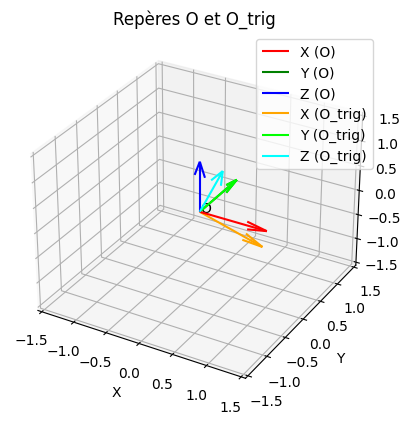

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_references(O, theta10):
    """
    Plote les repères O et O_trig tourné autour de l'axe y par theta10.

    Parameters:
    O (array): Coordonnées du point d'origine [0, 0, 0].
    theta10 (float): Angle de rotation autour de l'axe y (en degrés).
    """
    # Conversion de l'angle en radians
    theta10_rad = np.radians(theta10)

    # Base du repère O (d'origine)
    base_O = np.array([
        [1, 0, 0],  # Axe X
        [0, 1, 0],  # Axe Y
        [0, 0, 1]   # Axe Z
    ])

    # Matrice de rotation autour de l'axe y pour le repère trig
    rotation_y = np.array([
        [np.cos(theta10_rad), 0, np.sin(theta10_rad)],
        [0, 1, 0],
        [-np.sin(theta10_rad), 0, np.cos(theta10_rad)]
    ])

    # Base du repère O_trig
    base_O_trig = base_O @ rotation_y.T

    # Création de la figure 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Tracer les axes du repère O
    ax.quiver(O[0], O[1], O[2], base_O[0, 0], base_O[0, 1], base_O[0, 2], color='r', label='X (O)')
    ax.quiver(O[0], O[1], O[2], base_O[1, 0], base_O[1, 1], base_O[1, 2], color='g', label='Y (O)')
    ax.quiver(O[0], O[1], O[2], base_O[2, 0], base_O[2, 1], base_O[2, 2], color='b', label='Z (O)')

    # Tracer les axes du repère O_trig
    ax.quiver(O[0], O[1], O[2], base_O_trig[0, 0], base_O_trig[0, 1], base_O_trig[0, 2], color='orange', label='X (O_trig)')
    ax.quiver(O[0], O[1], O[2], base_O_trig[1, 0], base_O_trig[1, 1], base_O_trig[1, 2], color='lime', label='Y (O_trig)')
    ax.quiver(O[0], O[1], O[2], base_O_trig[2, 0], base_O_trig[2, 1], base_O_trig[2, 2], color='cyan', label='Z (O_trig)')

    # Annotation des points d'origine
    ax.text(O[0], O[1], O[2], 'O', color='black')

    # Configuration des axes
    max_range = 1.5
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Légendes et titre
    ax.legend()
    ax.set_title("Repères O et O_trig")

    plt.show()

# Exemple d'utilisation
O = np.array([0, 0, 0])  # Origine du repère
theta10 = 20  # Angle de rotation autour de l'axe y (en degrés)
plot_references(O, theta10)
